In [156]:
# %pip install fuzzywuzzy

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict, Counter
import unicodedata 
from difflib import get_close_matches
from fuzzywuzzy import process, fuzz

import os
from pathlib import Path

# tắt warning
import warnings
warnings.filterwarnings("ignore")

In [158]:
current_path = Path().resolve()
while current_path.name != "ADS_Final":
    if current_path.parent == current_path:
        raise FileNotFoundError("❌ Không tìm thấy thư mục gốc 'ADS_Final'")
    current_path = current_path.parent

os.chdir(current_path)

In [159]:
# os.chdir(r'D:\University\Applied Data Science\ADS_Final')

In [160]:
df_diemchuan_2024 = pd.read_csv('Data/diem_chuan_2024_final.csv')
df_diemchuan_2024

,Trường đào tạo,Mã ngành,Tên ngành,Tổ hợp môn,Điểm chuẩn,Ghi chú
0,KHA - Đại Học Kinh Tế Quốc Dân,7220201,Ngôn ngữ Anh,A01; D01; D09; D10,35.60,Môn Tiếng Anh hệ số 2
1,KHA - Đại Học Kinh Tế Quốc Dân,7310101_1,Kinh tế học (ngành Kinh tế),A00; A01; D01; D07,27.20,NaN
2,KHA - Đại Học Kinh Tế Quốc Dân,7310101_2,Kinh tế và quản lý đô thị (ngành Kinh tế),A00; A01; D01; D07,27.01,NaN
3,KHA - Đại Học Kinh Tế Quốc Dân,7310101_3,Kinh tế và quản lý nguồn nhân lực (ngành Kinh tế),A00; A01; D01; D07,27.34,NaN
4,KHA - Đại Học Kinh Tế Quốc Dân,7310104,Kinh tế đầu tư,A00; A01; D01; D07,27.40,NaN
...,...,...,...,...,...,...
5920,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720101,Y khoa,A00; A02; B00; B08,24.00,NaN
5921,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720201,Dược học,B00; A00; D07,21.00,NaN
5922,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720301,Điều dưỡng,A00; A02; B00; B08,21.00,NaN
5923,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720701,Y tế công cộng,A00; A02; B00; B08,16.00,NaN


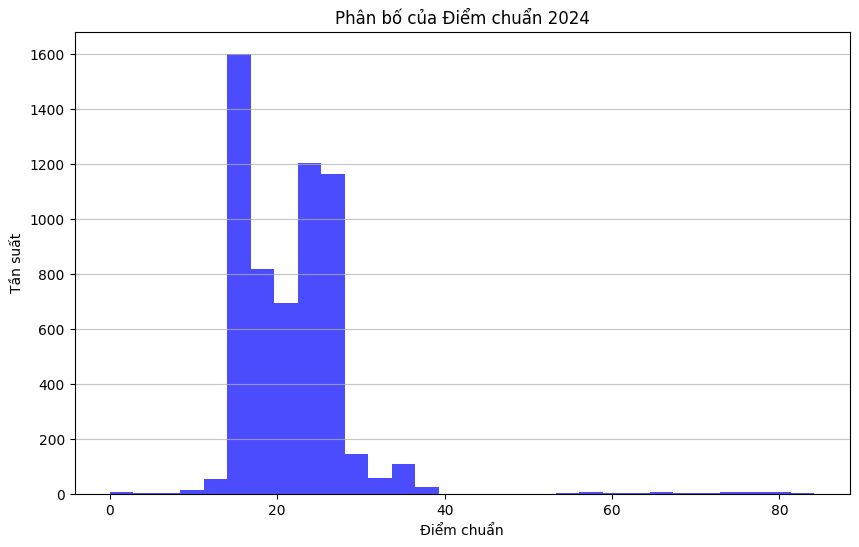

In [161]:
# Vẽ phân bố của cột "Điểm chuẩn"
plt.figure(figsize=(10, 6))
plt.hist(df_diemchuan_2024['Điểm chuẩn'], bins=30, color='blue', alpha=0.7)

plt.title('Phân bố của Điểm chuẩn 2024')
plt.xlabel('Điểm chuẩn')
plt.ylabel('Tần suất')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Xóa các dòng có điểm chuẩn là 0 và lớn hơn 40 do nhóm chỉ xét THPTQG và THPTQG thang 40

In [162]:
# drop các dòng có điểm chuẩn là 0 và lớn hơn 40
df_diemchuan_2024 = df_diemchuan_2024[(df_diemchuan_2024['Điểm chuẩn'] > 0) & (df_diemchuan_2024['Điểm chuẩn'] <= 40)]
df_diemchuan_2024

,Trường đào tạo,Mã ngành,Tên ngành,Tổ hợp môn,Điểm chuẩn,Ghi chú
0,KHA - Đại Học Kinh Tế Quốc Dân,7220201,Ngôn ngữ Anh,A01; D01; D09; D10,35.60,Môn Tiếng Anh hệ số 2
1,KHA - Đại Học Kinh Tế Quốc Dân,7310101_1,Kinh tế học (ngành Kinh tế),A00; A01; D01; D07,27.20,NaN
2,KHA - Đại Học Kinh Tế Quốc Dân,7310101_2,Kinh tế và quản lý đô thị (ngành Kinh tế),A00; A01; D01; D07,27.01,NaN
3,KHA - Đại Học Kinh Tế Quốc Dân,7310101_3,Kinh tế và quản lý nguồn nhân lực (ngành Kinh tế),A00; A01; D01; D07,27.34,NaN
4,KHA - Đại Học Kinh Tế Quốc Dân,7310104,Kinh tế đầu tư,A00; A01; D01; D07,27.40,NaN
...,...,...,...,...,...,...
5920,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720101,Y khoa,A00; A02; B00; B08,24.00,NaN
5921,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720201,Dược học,B00; A00; D07,21.00,NaN
5922,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720301,Điều dưỡng,A00; A02; B00; B08,21.00,NaN
5923,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720701,Y tế công cộng,A00; A02; B00; B08,16.00,NaN


In [163]:
# in ra các giá trị unique của cột "Ghi chú"
unique_notes = df_diemchuan_2024['Ghi chú'].unique()
print("Các giá trị unique của cột 'Ghi chú':")
for note in unique_notes:
    print(note)

Các giá trị unique của cột 'Ghi chú':
Môn Tiếng Anh hệ số 2
nan
Môn Toán hệ số 2
Tiếng Anh hệ số 2
CT định hướng CCQT, Tiếng Anh hệ số 2
Thang điểm 40, Toán x2
TTNV=1
TTNV<=6
TTNV<=2
TTNV<=13
TTNV<=3
TTNV<=4
TTNV<=10
TTNV<=16
TTNV<=11
TTNV<=5
TTNV= 1
Phân hiệu Long An
Phân hiệu TPHCM
Tổng điểm 3 môn: 25.25, môn 1: 9.25, môn 2: 8.00, môn 3: 8.00
Tổng điểm 3 môn: 22, môn 1: 7.00, môn 2: 7.00, môn 3: 8.00
Tổng điểm 3 môn: 24.15, môn 1: 8.00, môn 2: 8.40, môn 3: 7.75
Tổng điểm 3 môn: 24.4, môn 1: 9.00, môn 2: 8.00, môn 3: 7.40
Tổng điểm 3 môn: 23, môn 1: 6.00, môn 2: 8.60, môn 3: 8.40
Tổng điểm 3 môn: 20.05, môn 1: 7.75, môn 2: 5.50, môn 3: 6.80
Tổng điểm 3 môn: 25.55, môn 1: 8.75, môn 2: 8.00, môn 3: 8.80
Tổng điểm 3 môn: 20, môn 1: 6.75, môn 2: 6.25, môn 3: 7.00
CT tăng cường tiếng Anh
Đối với nam (Không tuyển nữ)
Đối với Nam
Nam, vùng 3, bài thi CA2
Nữ, phía Nam
Nam, vùng 1, bài thi CA2
Tiếng Anh hệ số 2, Cơ sở Nam Định
Tiếng Anh hệ số 2, Cơ sở Hà Nội
Cơ sở Nam Định
Cơ sở Hà Nội
TS nam 

In [164]:
def classify_loai_diem(diem_chuan, ghi_chu):
    if pd.isna(diem_chuan):
        return "THPTQG"
    
    if diem_chuan > 30:
        return "THPTQG - Thang 40"
    
    if isinstance(ghi_chu, str):
        ghi_chu_lower = ghi_chu.lower()
        keywords = ["hệ số 2", "nhân 2", "x2", "thang điểm 40"]
        if any(kw in ghi_chu_lower for kw in keywords):
            return "THPTQG - Thang 40"

    return "THPTQG"

# Áp dụng vào DataFrame
df_diemchuan_2024["Loại điểm"] = df_diemchuan_2024.apply(
    lambda row: classify_loai_diem(row["Điểm chuẩn"], row["Ghi chú"]), axis=1
)

df_diemchuan_2024

,Trường đào tạo,Mã ngành,Tên ngành,Tổ hợp môn,Điểm chuẩn,Ghi chú,Loại điểm
0,KHA - Đại Học Kinh Tế Quốc Dân,7220201,Ngôn ngữ Anh,A01; D01; D09; D10,35.60,Môn Tiếng Anh hệ số 2,THPTQG - Thang 40
1,KHA - Đại Học Kinh Tế Quốc Dân,7310101_1,Kinh tế học (ngành Kinh tế),A00; A01; D01; D07,27.20,NaN,THPTQG
2,KHA - Đại Học Kinh Tế Quốc Dân,7310101_2,Kinh tế và quản lý đô thị (ngành Kinh tế),A00; A01; D01; D07,27.01,NaN,THPTQG
3,KHA - Đại Học Kinh Tế Quốc Dân,7310101_3,Kinh tế và quản lý nguồn nhân lực (ngành Kinh tế),A00; A01; D01; D07,27.34,NaN,THPTQG
4,KHA - Đại Học Kinh Tế Quốc Dân,7310104,Kinh tế đầu tư,A00; A01; D01; D07,27.40,NaN,THPTQG
...,...,...,...,...,...,...,...
5920,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720101,Y khoa,A00; A02; B00; B08,24.00,NaN,THPTQG
5921,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720201,Dược học,B00; A00; D07,21.00,NaN,THPTQG
5922,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720301,Điều dưỡng,A00; A02; B00; B08,21.00,NaN,THPTQG
5923,BMU - Trường Đại học Y Dược Buôn Ma Thuột,7720701,Y tế công cộng,A00; A02; B00; B08,16.00,NaN,THPTQG


### Tách cột "Trường đào tạo" thành "Mã trường" và "Trường đào tạo" để xử lý với data có chứa nhóm ngành và mã ngành

In [165]:
# Tách cột "Trường đào tạo" thành "Mã trường" và "Tên trường" (tạm thời)
df_diemchuan_2024[["Mã trường", "Tên trường"]] = df_diemchuan_2024["Trường đào tạo"].str.extract(r"^(\S+)\s*-\s*(.+)$")

# Xóa cột gốc
df_diemchuan_2024.drop(columns=["Trường đào tạo"], inplace=True)

# Đổi tên "Tên trường" thành "Trường đào tạo"
df_diemchuan_2024.rename(columns={"Tên trường": "Trường đào tạo"}, inplace=True)

# Đưa 2 cột lên đầu
cols = ["Mã trường", "Trường đào tạo"] + [col for col in df_diemchuan_2024.columns if col not in ["Mã trường", "Trường đào tạo"]]
df_diemchuan_2024 = df_diemchuan_2024[cols]

df_diemchuan_2024

,Mã trường,Trường đào tạo,Mã ngành,Tên ngành,Tổ hợp môn,Điểm chuẩn,Ghi chú,Loại điểm
0,KHA,Đại Học Kinh Tế Quốc Dân,7220201,Ngôn ngữ Anh,A01; D01; D09; D10,35.60,Môn Tiếng Anh hệ số 2,THPTQG - Thang 40
1,KHA,Đại Học Kinh Tế Quốc Dân,7310101_1,Kinh tế học (ngành Kinh tế),A00; A01; D01; D07,27.20,NaN,THPTQG
2,KHA,Đại Học Kinh Tế Quốc Dân,7310101_2,Kinh tế và quản lý đô thị (ngành Kinh tế),A00; A01; D01; D07,27.01,NaN,THPTQG
3,KHA,Đại Học Kinh Tế Quốc Dân,7310101_3,Kinh tế và quản lý nguồn nhân lực (ngành Kinh tế),A00; A01; D01; D07,27.34,NaN,THPTQG
4,KHA,Đại Học Kinh Tế Quốc Dân,7310104,Kinh tế đầu tư,A00; A01; D01; D07,27.40,NaN,THPTQG
...,...,...,...,...,...,...,...,...
5920,BMU,Trường Đại học Y Dược Buôn Ma Thuột,7720101,Y khoa,A00; A02; B00; B08,24.00,NaN,THPTQG
5921,BMU,Trường Đại học Y Dược Buôn Ma Thuột,7720201,Dược học,B00; A00; D07,21.00,NaN,THPTQG
5922,BMU,Trường Đại học Y Dược Buôn Ma Thuột,7720301,Điều dưỡng,A00; A02; B00; B08,21.00,NaN,THPTQG
5923,BMU,Trường Đại học Y Dược Buôn Ma Thuột,7720701,Y tế công cộng,A00; A02; B00; B08,16.00,NaN,THPTQG


In [166]:
df_nganh_dao_tao = pd.read_csv('Data/nganh_dao_tao_final_2.csv')
df_nganh_dao_tao

,Nhóm ngành,Ngành,Trường đào tạo,Mã ngành,Tên ngành,Tổ hợp môn,Điểm chuẩn 2024,Ghi chú
0,Kế toán - Kiểm toán,Kế toán,Đại Học Kinh Tế Quốc Dân,7340301,Kế toán,A00; A01; D01; D07,27.29,NaN
1,Kế toán - Kiểm toán,Kế toán,Đại Học Kinh Tế Quốc Dân,EP04,Kế toán tích hợp chứng chi quốc tế (JCAEW CFAB),A00; A01; D01; D07,27.20,NaN
2,Kế toán - Kiểm toán,Kế toán,Đại Học Bách Khoa Hà Nội,EM4,Kế toán,"A00; A01; D01; K01 (Toán, Văn, Lý/Hóa/Sinh/Tin)",25.80,NaN
3,Kế toán - Kiểm toán,Kế toán,Học Viện Tài chính,7340301,Kế toán,A00; A01; D01; D07,26.45,NaN
4,Kế toán - Kiểm toán,Kế toán,Học Viện Tài chính,7340301C21,Kế toán doanh nghiệp (theo định hướng ACCA),A01; D01; D07,34.35,"CT định hướng CCQT, Tiếng Anh hệ số 2"
...,...,...,...,...,...,...,...,...
5022,Khoa học tư nhiên khác,Vật lý học,Trường Đại Học Khoa Học Tự Nhiên TPHCM,7440102_DKD,Vật lý học (CT tăng cường tiếng Anh),"A00; A01; C01; C03; A04; A10; (Toán, Lí, Công ...",NaN,NaN
5023,Khoa học tư nhiên khác,Vật lý học,Trường Đại Học Khoa Học Tự Nhiên TPHCM,7440102_NN,"Nhóm ngành Vật lý học, Công nghệ Vật lý điện t...","A00; A01; C01; C03; A04; A10; (Toán, Lí, Công ...",NaN,NaN
5024,Khoa học tư nhiên khác,Vật lý học,Trường Đại Học Khoa Học Tự Nhiên Hà Nội,QHT03,Vật lý học,A00; A01; A02; C01,25.30,NaN
5025,Khoa học tư nhiên khác,Vật lý học,Trường Đại Học Khoa Học Huế,7440102,Vật lý học,"A00; A01; C01; (Toán, Lí, Tin)",NaN,NaN


In [167]:
merged_df = df_diemchuan_2024.merge(
    df_nganh_dao_tao[["Trường đào tạo", "Mã ngành", "Nhóm ngành", "Ngành"]],
    on=["Trường đào tạo", "Mã ngành"],
    how="left"
)

# Đưa cột 'Nhóm ngành' và 'Ngành' vào ngay sau 'Trường đào tạo'
cols = list(merged_df.columns)
for col in ["Nhóm ngành", "Ngành"]:
    if col in cols:
        cols.remove(col)
        insert_at = cols.index("Trường đào tạo") + 1
        cols.insert(insert_at, col)
merged_df = merged_df[cols]


In [168]:
# Số dòng có Ngành và Nhóm ngành bị trống
missing_count = merged_df[["Nhóm ngành", "Ngành"]].isnull().sum()
print("Số dòng có Ngành và Nhóm ngành bị trống:")
print(missing_count)

Số dòng có Ngành và Nhóm ngành bị trống:
Nhóm ngành    799
Ngành         799
dtype: int64


In [169]:
# Tạo mapping từ Mã ngành → (Ngành, Nhóm ngành) từ df_nganh
nganh_mapping = (
    df_nganh_dao_tao.dropna(subset=["Ngành", "Nhóm ngành"])
    .drop_duplicates(subset=["Mã ngành"])
    .set_index("Mã ngành")[["Ngành", "Nhóm ngành"]]
    .to_dict(orient="index")
)

# Hàm bổ sung nếu thiếu
def fill_missing_fields(row):
    if pd.isna(row["Ngành"]) or pd.isna(row["Nhóm ngành"]):
        info = nganh_mapping.get(row["Mã ngành"])
        if info:
            row["Ngành"] = row["Ngành"] if pd.notna(row["Ngành"]) else info["Ngành"]
            row["Nhóm ngành"] = row["Nhóm ngành"] if pd.notna(row["Nhóm ngành"]) else info["Nhóm ngành"]
    return row

# Áp dụng
merged_df = merged_df.apply(fill_missing_fields, axis=1)

In [170]:
# Số dòng có Ngành và Nhóm ngành bị trống
missing_count = merged_df[["Nhóm ngành", "Ngành"]].isnull().sum()
print("Số dòng có Ngành và Nhóm ngành bị trống:")
print(missing_count)

Số dòng có Ngành và Nhóm ngành bị trống:
Nhóm ngành    598
Ngành         598
dtype: int64


In [171]:
# Lọc các dòng KHÔNG bị thiếu (để xây danh sách từ khóa thực tế)
df_non_missing = merged_df.dropna(subset=["Ngành", "Nhóm ngành"])

# Thống kê các từ xuất hiện nhiều nhất trong "Tên ngành" kèm theo ngành và nhóm ngành tương ứng
keyword_map = defaultdict(Counter)

# Duyệt qua các dòng đủ thông tin
for _, row in df_non_missing.iterrows():
    ten_nganh = str(row["Tên ngành"]).lower()
    nganh = row["Ngành"]
    nhom_nganh = row["Nhóm ngành"]
    
    for word in ten_nganh.split():
        if len(word) >= 4:  # chỉ lấy từ dài ≥ 4 ký tự để tránh nhiễu
            keyword_map[word][(nganh, nhom_nganh)] += 1

# Tạo bảng từ khóa phổ biến (xuất hiện ít nhất 3 lần)
keyword_rules = []
for word, nganh_counter in keyword_map.items():
    most_common = nganh_counter.most_common(1)[0]
    if most_common[1] >= 3:
        keyword_rules.append({
            "keyword": word,
            "nganh": most_common[0][0],
            "nhom_nganh": most_common[0][1],
            "count": most_common[1]
        })

# Sắp xếp theo độ phổ biến
keyword_df = pd.DataFrame(keyword_rules).sort_values(by="count", ascending=False).reset_index(drop=True)

In [172]:
# Tạo từ điển từ keyword sang (Ngành, Nhóm ngành)
keyword_lookup = {
    row["keyword"]: (row["nganh"], row["nhom_nganh"])
    for _, row in keyword_df.iterrows()
}

# Hàm áp dụng nếu thiếu
def fill_by_keyword(row):
    if pd.isna(row["Ngành"]) or pd.isna(row["Nhóm ngành"]):
        ten_nganh = str(row["Tên ngành"]).lower()
        for word in ten_nganh.split():
            if word in keyword_lookup:
                nganh, nhom_nganh = keyword_lookup[word]
                if pd.isna(row["Ngành"]):
                    row["Ngành"] = nganh
                if pd.isna(row["Nhóm ngành"]):
                    row["Nhóm ngành"] = nhom_nganh
                break
    return row

# Áp dụng vào các dòng bị thiếu
merged_df = merged_df.apply(fill_by_keyword, axis=1)

In [173]:
# Số dòng có Ngành và Nhóm ngành bị trống
missing_count = merged_df[["Nhóm ngành", "Ngành"]].isnull().sum()
print("Số dòng có Ngành và Nhóm ngành bị trống:")
print(missing_count)

Số dòng có Ngành và Nhóm ngành bị trống:
Nhóm ngành    43
Ngành         43
dtype: int64


In [174]:
# Ghép theo Mã ngành nếu bị thiếu Ngành và Nhóm ngành
filled_df = merged_df.copy()

# Tạo bảng tra cứu mã ngành
ref_df = filled_df.dropna(subset=["Ngành", "Nhóm ngành"]).drop_duplicates(subset=["Mã ngành"])
ma_nganh_to_info = ref_df.set_index("Mã ngành")[["Ngành", "Nhóm ngành"]].to_dict("index")

# Áp dụng vào các dòng bị thiếu
def fill_from_ma_nganh(row):
    if pd.isna(row["Ngành"]) or pd.isna(row["Nhóm ngành"]):
        ma_nganh = row["Mã ngành"]
        if ma_nganh in ma_nganh_to_info:
            if pd.isna(row["Ngành"]):
                row["Ngành"] = ma_nganh_to_info[ma_nganh]["Ngành"]
            if pd.isna(row["Nhóm ngành"]):
                row["Nhóm ngành"] = ma_nganh_to_info[ma_nganh]["Nhóm ngành"]
    return row

filled_df = filled_df.apply(fill_from_ma_nganh, axis=1)

# Ghép gần giống theo Tên ngành bằng fuzzy matching
ref_names = ref_df["Tên ngành"].unique()

def fuzzy_fill(row):
    if pd.isna(row["Ngành"]) or pd.isna(row["Nhóm ngành"]):
        ten_nganh = row["Tên ngành"]
        matches = get_close_matches(ten_nganh, ref_names, n=1, cutoff=0.9)
        if matches:
            matched_row = ref_df[ref_df["Tên ngành"] == matches[0]].iloc[0]
            if pd.isna(row["Ngành"]):
                row["Ngành"] = matched_row["Ngành"]
            if pd.isna(row["Nhóm ngành"]):
                row["Nhóm ngành"] = matched_row["Nhóm ngành"]
    return row

filled_df = filled_df.apply(fuzzy_fill, axis=1)

In [175]:
# Số dòng có Ngành và Nhóm ngành bị trống
missing_count = filled_df[["Nhóm ngành", "Ngành"]].isnull().sum()
print("Số dòng có Ngành và Nhóm ngành bị trống:")
print(missing_count)

Số dòng có Ngành và Nhóm ngành bị trống:
Nhóm ngành    36
Ngành         36
dtype: int64


In [176]:
# 1. Tạo tập tham chiếu chuẩn
ref_df = filled_df.dropna(subset=["Ngành", "Nhóm ngành"]).drop_duplicates(subset=["Tên ngành", "Trường đào tạo"])

# 2. Chuẩn hóa tên ngành: bỏ cụm từ không cần thiết
def clean_name(name):
    if pd.isna(name):
        return ""
    return re.sub(r"\s*\(.*?\)|CT.*?|\s*C.*?C.*?", "", name).strip().lower()

# Tạo thêm cột tên ngành rút gọn
filled_df["Tên ngành gọn"] = filled_df["Tên ngành"].apply(clean_name)
ref_df["Tên ngành gọn"] = ref_df["Tên ngành"].apply(clean_name)

# Lấy duy nhất mỗi cặp Tên ngành gọn + Trường
ref_unique = ref_df.drop_duplicates(subset=["Tên ngành gọn", "Trường đào tạo"], keep="first")

# 3. Tạo từ điển tra cứu
lookup = ref_unique.set_index(["Tên ngành gọn", "Trường đào tạo"])[["Ngành", "Nhóm ngành"]].to_dict("index")

# 4. Hàm điền dữ liệu nâng cao
def advanced_fill(row):
    if pd.isna(row["Ngành"]) or pd.isna(row["Nhóm ngành"]):
        ten_nganh_gon = clean_name(row["Tên ngành"])
        truong = row["Trường đào tạo"]

        # Ưu tiên ghép theo tên ngành gọn + trường
        key = (ten_nganh_gon, truong)
        if key in lookup:
            if pd.isna(row["Ngành"]):
                row["Ngành"] = lookup[key]["Ngành"]
            if pd.isna(row["Nhóm ngành"]):
                row["Nhóm ngành"] = lookup[key]["Nhóm ngành"]
        else:
            # Nếu chưa có, ghép fuzzy tên ngành gọn
            candidates = ref_df["Tên ngành gọn"].unique()
            matches = get_close_matches(ten_nganh_gon, candidates, n=1, cutoff=0.85)
            if matches:
                match = matches[0]
                matched_row = ref_df[ref_df["Tên ngành gọn"] == match].iloc[0]
                if pd.isna(row["Ngành"]):
                    row["Ngành"] = matched_row["Ngành"]
                if pd.isna(row["Nhóm ngành"]):
                    row["Nhóm ngành"] = matched_row["Nhóm ngành"]
    return row

# 5. Áp dụng cho toàn bộ
filled_df = filled_df.apply(advanced_fill, axis=1)

# 6. Xóa cột phụ và lưu lại
filled_df = filled_df.drop(columns=["Tên ngành gọn"])

In [177]:
# Số dòng có Ngành và Nhóm ngành bị trống
missing_count = filled_df[["Nhóm ngành", "Ngành"]].isnull().sum()
print("Số dòng có Ngành và Nhóm ngành bị trống:")
print(missing_count)

Số dòng có Ngành và Nhóm ngành bị trống:
Nhóm ngành    31
Ngành         31
dtype: int64


In [178]:
def clean_name(name):
    if pd.isna(name): return ""
    name = name.lower()
    name = re.sub(r"\(.*?\)", "", name)  # xóa nội dung trong ngoặc
    name = unicodedata.normalize("NFD", name).encode("ascii", "ignore").decode("utf-8")
    name = re.sub(r"[^\w\s]", "", name).strip()
    return name

# 1. Tạo bản sao
merged_df_filled = filled_df.copy()

# 2. Chuẩn hóa tên ngành
merged_df_filled["Tên ngành gọn"] = merged_df_filled["Tên ngành"].apply(clean_name)
ref_df["Tên ngành gọn"] = ref_df["Tên ngành"].apply(clean_name)

# 3. Tạo từ điển {Tên ngành gọn: (Ngành phổ biến, Nhóm ngành phổ biến)}
major_mode_lookup = (
    ref_df.groupby("Tên ngành gọn")[["Ngành", "Nhóm ngành"]]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "")
    .to_dict("index")
)

# 4. Điền dữ liệu còn thiếu
def fill_missing(row):
    if pd.isna(row["Ngành"]) and pd.isna(row["Nhóm ngành"]):
        key = row["Tên ngành gọn"]
        if key in major_mode_lookup:
            return pd.Series(major_mode_lookup[key])
        else:
            return pd.Series(["Đang cập nhật", "Khác"])
    else:
        return pd.Series([row["Ngành"], row["Nhóm ngành"]])

merged_df_filled[["Ngành", "Nhóm ngành"]] = merged_df_filled.apply(fill_missing, axis=1)

# 5. Xóa cột phụ
merged_df_filled.drop(columns=["Tên ngành gọn"], inplace=True)

In [179]:
# Số dòng có Ngành và Nhóm ngành bị trống
missing_count = merged_df_filled[["Nhóm ngành", "Ngành"]].isnull().sum()
print("Số dòng có Ngành và Nhóm ngành bị trống:")
print(missing_count)

Số dòng có Ngành và Nhóm ngành bị trống:
Nhóm ngành    0
Ngành         0
dtype: int64


In [180]:
# Tạo dict ánh xạ (mapping) từ (Trường đào tạo, Mã ngành) → Tổ hợp môn đầu tiên tìm thấy
mapping = (
    df_nganh_dao_tao.dropna(subset=["Tổ hợp môn"])
    .drop_duplicates(subset=["Trường đào tạo", "Mã ngành"])
    .set_index(["Trường đào tạo", "Mã ngành"])["Tổ hợp môn"]
    .to_dict()
)

# Bổ sung tổ hợp môn bị thiếu
def fill_missing_to_hop(row):
    if pd.isna(row["Tổ hợp môn"]):
        return mapping.get((row["Trường đào tạo"], row["Mã ngành"]), None)
    return row["Tổ hợp môn"]

merged_df_filled["Tổ hợp môn"] = merged_df.apply(fill_missing_to_hop, axis=1)

In [181]:
# đếm số dòng có tổ hợp môn bị thiếu
missing_count = merged_df_filled["Tổ hợp môn"].isna().sum()
print(f"🔍 Số dòng có Tổ hợp môn bị thiếu: {missing_count}")

🔍 Số dòng có Tổ hợp môn bị thiếu: 3


In [182]:
# Tạo phiên bản chuẩn hóa để tra cứu
def clean_name(name):
    if pd.isna(name): return ""
    name = name.lower()
    name = re.sub(r"\(.*?\)", "", name)
    name = unicodedata.normalize("NFD", name).encode("ascii", "ignore").decode("utf-8")
    name = re.sub(r"[^\w\s]", "", name).strip()
    return name

merged_df_filled["Tên ngành gọn"] = merged_df_filled["Tên ngành"].apply(clean_name)

# Tạo bảng lookup tổ hợp phổ biến theo Mã ngành + Trường đào tạo
tohop_lookup = (
    merged_df_filled[~merged_df_filled["Tổ hợp môn"].isna()]
    .groupby(["Mã ngành", "Trường đào tạo"])["Tổ hợp môn"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "")
    .to_dict()
)

# Tạo thêm lookup theo Tên ngành gọn
tohop_by_major = (
    merged_df_filled[~merged_df_filled["Tổ hợp môn"].isna()]
    .groupby("Tên ngành gọn")["Tổ hợp môn"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "")
    .to_dict()
)

# Hàm điền
def fill_missing_tohop(row):
    if pd.isna(row["Tổ hợp môn"]):
        key1 = (row["Mã ngành"], row["Trường đào tạo"])
        key2 = row["Tên ngành gọn"]
        if key1 in tohop_lookup:
            return tohop_lookup[key1]
        elif key2 in tohop_by_major:
            return tohop_by_major[key2]
        else:
            return "Đang cập nhật"
    return row["Tổ hợp môn"]

# Áp dụng
merged_df_filled["Tổ hợp môn"] = merged_df_filled.apply(fill_missing_tohop, axis=1)
merged_df_filled.drop(columns=["Tên ngành gọn"], inplace=True)

In [183]:
# đếm số dòng có tổ hợp môn bị thiếu
missing_count = merged_df_filled["Tổ hợp môn"].isna().sum()
print(f"🔍 Số dòng có Tổ hợp môn bị thiếu: {missing_count}")

🔍 Số dòng có Tổ hợp môn bị thiếu: 0


In [184]:
# Tách tổ hợp môn ra thành nhiều dòng nếu có dấu ;
df_expanded = merged_df_filled.assign(**{
    "Tổ hợp môn": merged_df_filled["Tổ hợp môn"].str.split(";")
}).explode("Tổ hợp môn")

# Xóa khoảng trắng thừa
df_expanded["Tổ hợp môn"] = df_expanded["Tổ hợp môn"].str.strip()

df_expanded.reset_index(drop=True, inplace=True)

df_expanded

,Mã trường,Trường đào tạo,Ngành,Nhóm ngành,Mã ngành,Tên ngành,Tổ hợp môn,Điểm chuẩn,Ghi chú,Loại điểm
0,KHA,Đại Học Kinh Tế Quốc Dân,Ngôn ngữ Anh,Công an - Quân đội,7220201,Ngôn ngữ Anh,A01,35.60,Môn Tiếng Anh hệ số 2,THPTQG - Thang 40
1,KHA,Đại Học Kinh Tế Quốc Dân,Ngôn ngữ Anh,Công an - Quân đội,7220201,Ngôn ngữ Anh,D01,35.60,Môn Tiếng Anh hệ số 2,THPTQG - Thang 40
2,KHA,Đại Học Kinh Tế Quốc Dân,Ngôn ngữ Anh,Công an - Quân đội,7220201,Ngôn ngữ Anh,D09,35.60,Môn Tiếng Anh hệ số 2,THPTQG - Thang 40
3,KHA,Đại Học Kinh Tế Quốc Dân,Ngôn ngữ Anh,Công an - Quân đội,7220201,Ngôn ngữ Anh,D10,35.60,Môn Tiếng Anh hệ số 2,THPTQG - Thang 40
4,KHA,Đại Học Kinh Tế Quốc Dân,Kinh tế,Kinh tế - Quản trị kinh doanh - Thương Mại,7310101_1,Kinh tế học (ngành Kinh tế),A00,27.20,NaN,THPTQG
...,...,...,...,...,...,...,...,...,...,...
20001,BMU,Trường Đại học Y Dược Buôn Ma Thuột,Y tế công cộng,Y - Dược,7720701,Y tế công cộng,B08,16.00,NaN,THPTQG
20002,DDG,Khoa Giáo dục thể chất Đà Nẵng,Giáo dục Thể chất,Sư phạm - Giáo dục,7140206,Giáo dục thể chất,T00,18.93,NK3 >= 6.25; TTNV <= 4,THPTQG
20003,DDG,Khoa Giáo dục thể chất Đà Nẵng,Giáo dục Thể chất,Sư phạm - Giáo dục,7140206,Giáo dục thể chất,T02,18.93,NK3 >= 6.25; TTNV <= 4,THPTQG
20004,DDG,Khoa Giáo dục thể chất Đà Nẵng,Giáo dục Thể chất,Sư phạm - Giáo dục,7140206,Giáo dục thể chất,T05,18.93,NK3 >= 6.25; TTNV <= 4,THPTQG


In [185]:
df_expanded.to_csv("Data/diem_chuan_2024_full.csv", index=False, encoding="utf-8-sig")

In [186]:
df_18_23 = pd.read_excel('Data/diemchuan_full_18-23.xlsx')
df_18_23

,Khu vực,Tỉnh/ Thành phố,Mã trường xét tuyển,Mã Trường,Tên Trường,Loại đơn vị,Mã nhóm ngành,Nhóm ngành,Mã phân ngành,Phân ngành,Mã xét tuyển,Tên Ngành,Loại điểm,Tổ hợp,Điểm chuẩn,Ghi chú,Năm
0,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,D01,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
1,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
2,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C19,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
3,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C20,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
4,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140218CLC,Sư phạm Lịch sử,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107105,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,722,Nhân văn,72202,"Ngôn ngữ, văn học và văn hóa nước ngoài",7220209,Ngôn ngữ Nhật,DGNLHCM,DGNLHCM,761.00,Đánh giá năng lực Đại học Quốc gia TPHCM,2023
107106,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,731,Khoa học xã hội và hành vi,73106,Khu vực học,7310601,Quốc tế học,DGNLHCM,DGNLHCM,648.00,Đánh giá năng lực Đại học Quốc gia TPHCM,2023
107107,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,722,Nhân văn,72202,"Ngôn ngữ, văn học và văn hóa nước ngoài",7220203,Ngôn ngữ Pháp,DGNLHCM,DGNLHCM,643.00,Đánh giá năng lực Đại học Quốc gia TPHCM,2023
107108,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,722,Nhân văn,72202,"Ngôn ngữ, văn học và văn hóa nước ngoài",7220202,Ngôn ngữ Nga,DGNLHCM,DGNLHCM,613.00,Đánh giá năng lực Đại học Quốc gia TPHCM,2023


In [187]:
# lọc ra "Loại điểm" là "THPTQG" và "THPTQG - Thang 40"
df_18_23_filtered = df_18_23[df_18_23["Loại điểm"].isin(["THPTQG", "THPTQG - Thang 40"])]
df_18_23_filtered.reset_index(drop=True, inplace=True)
df_18_23_filtered

,Khu vực,Tỉnh/ Thành phố,Mã trường xét tuyển,Mã Trường,Tên Trường,Loại đơn vị,Mã nhóm ngành,Nhóm ngành,Mã phân ngành,Phân ngành,Mã xét tuyển,Tên Ngành,Loại điểm,Tổ hợp,Điểm chuẩn,Ghi chú,Năm
0,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,D01,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
1,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
2,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C19,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
3,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C20,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
4,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140218CLC,Sư phạm Lịch sử,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77277,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,722,Nhân văn,72202,"Ngôn ngữ, văn học và văn hóa nước ngoài",7220202,Ngôn ngữ Nga,THPTQG,D01,15.04,"TTNV<=5; Tổ hợp D01, D78, D96 điểm chuẩn cao h...",2023
77278,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,722,Nhân văn,72202,"Ngôn ngữ, văn học và văn hóa nước ngoài",7220202,Ngôn ngữ Nga,THPTQG,D96,15.04,"TTNV<=5; Tổ hợp D01, D78, D96 điểm chuẩn cao h...",2023
77279,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,722,Nhân văn,72202,"Ngôn ngữ, văn học và văn hóa nước ngoài",7220202,Ngôn ngữ Nga,THPTQG,D78,15.04,"TTNV<=5; Tổ hợp D01, D78, D96 điểm chuẩn cao h...",2023
77280,Miền Trung - Tây Nguyên,Đà Nẵng,DDF,UFLS,Đại Học Ngoại Ngữ – Đại Học Đà Nẵng,Công lập,722,Nhân văn,72202,"Ngôn ngữ, văn học và văn hóa nước ngoài",7220202,Ngôn ngữ Nga,THPTQG,D02,15.04,"TTNV<=5; Tổ hợp D01, D78, D96 điểm chuẩn cao h...",2023


In [188]:
# lưu lại file csv
df_18_23_filtered.to_csv("Data/diem_chuan_2018-2023_full.csv", index=False, encoding="utf-8-sig")

In [189]:
# Chuẩn hóa file 2024
df_2024_standardized = pd.DataFrame({
    "Khu vực": None,
    "Tỉnh/ Thành phố": None,
    "Mã trường xét tuyển": df_expanded["Mã trường"],
    "Mã Trường": None,
    "Tên Trường": df_expanded["Trường đào tạo"],
    "Loại đơn vị": None,
    "Mã nhóm ngành": None,
    "Nhóm ngành": df_expanded.get("Nhóm ngành"),
    "Mã phân ngành": None,
    "Phân ngành": df_expanded.get("Ngành"),
    "Mã xét tuyển": df_expanded.get("Mã ngành"),
    "Tên Ngành": df_expanded["Tên ngành"],
    "Loại điểm": df_expanded["Loại điểm"],
    "Tổ hợp": df_expanded["Tổ hợp môn"],
    "Điểm chuẩn": df_expanded["Điểm chuẩn"],
    "Ghi chú": df_expanded["Ghi chú"],
    "Năm": 2024
})

# Gộp dữ liệu
df_merged = pd.concat([df_18_23_filtered, df_2024_standardized], ignore_index=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged

,Khu vực,Tỉnh/ Thành phố,Mã trường xét tuyển,Mã Trường,Tên Trường,Loại đơn vị,Mã nhóm ngành,Nhóm ngành,Mã phân ngành,Phân ngành,Mã xét tuyển,Tên Ngành,Loại điểm,Tổ hợp,Điểm chuẩn,Ghi chú,Năm
0,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,D01,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
1,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
2,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C19,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
3,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C20,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
4,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140218CLC,Sư phạm Lịch sử,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97283,None,None,BMU,None,Trường Đại học Y Dược Buôn Ma Thuột,None,None,Y - Dược,None,Y tế công cộng,7720701,Y tế công cộng,THPTQG,B08,16.00,NaN,2024
97284,None,None,DDG,None,Khoa Giáo dục thể chất Đà Nẵng,None,None,Sư phạm - Giáo dục,None,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T00,18.93,NK3 >= 6.25; TTNV <= 4,2024
97285,None,None,DDG,None,Khoa Giáo dục thể chất Đà Nẵng,None,None,Sư phạm - Giáo dục,None,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T02,18.93,NK3 >= 6.25; TTNV <= 4,2024
97286,None,None,DDG,None,Khoa Giáo dục thể chất Đà Nẵng,None,None,Sư phạm - Giáo dục,None,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T05,18.93,NK3 >= 6.25; TTNV <= 4,2024


In [190]:
# đếm số tên trường trước khi chuẩn hóa
unique_truong_count = df_merged["Tên Trường"].nunique()
print(f"Số lượng tên trường duy nhất trước khi chuẩn hóa: {unique_truong_count}")

Số lượng tên trường duy nhất trước khi chuẩn hóa: 539


In [191]:
df_merged.to_csv("Data/diem_chuan_full.csv", index=False, encoding="utf-8-sig")

In [192]:
df_merged_updated = df_merged.copy()

mapping_results = []
unique_2024 = df_merged_updated[df_merged_updated["Năm"] == 2024]["Tên Trường"].dropna().unique()
unique_18_23 = df_merged_updated[df_merged_updated["Năm"] < 2024]["Tên Trường"].dropna().unique()

for name_2024 in unique_2024:
    best_match = process.extractOne(name_2024, unique_18_23, scorer=fuzz.token_sort_ratio)
    if best_match:
        match_name, score = best_match[:2]
        mapping_results.append((name_2024, match_name, score))

df_mapping = pd.DataFrame(mapping_results, columns=["Tên Trường 2024", "Tên Trường 18-23", "Tỷ lệ giống (%)"])

In [193]:
df_mapping

,Tên Trường 2024,Tên Trường 18-23,Tỷ lệ giống (%)
0,Đại Học Kinh Tế Quốc Dân,Đại Học Kinh Tế Quốc Dân,100
1,Đại Học Bách Khoa Hà Nội,Đại Học Bách Khoa Hà Nội,100
2,Học Viện Tài chính,Học Viện Tài Chính,100
3,Học Viện Ngân Hàng,Học Viện Ngân Hàng,100
4,Trường Đại học Ngoại thương,Đại Học Thương Mại,76
...,...,...,...
286,Trường Đại học Nội vụ Hà Nội,Đại học Tài Nguyên và Môi Trường Hà Nội,79
287,Trường Sĩ Quan Kĩ Thuật Quân Sự - Hệ Quân sự -...,Trường Sĩ Quan Kĩ Thuật Quân Sự - Hệ Quân sự ...,100
288,Trường Đại Học Công Nghệ Đông Á,Đại Học Công Nghệ Đông Á,85
289,Trường Đại học Y Dược Buôn Ma Thuột,Đại học Y Dược Buôn Ma Thuột,89


In [194]:
df_mapping.to_csv("Data/mapping_ten_truong.csv", index=False, encoding="utf-8-sig")

In [195]:
# Dùng lại danh sách index sai đã được nhóm check tay
wrong_indices = [
    4, 13, 23, 31, 35, 44, 53, 54, 61, 62, 66, 70, 75, 78, 80, 81, 84, 87, 90, 91, 92, 95,
    96, 97, 102, 104, 106, 108, 122, 127, 130, 135, 146, 168, 171, 177, 183, 193, 196, 198,
    199, 200, 215, 226, 229, 232, 235, 240, 243, 245, 248, 255, 256, 257, 266, 269, 271,
    274, 276, 277, 278, 280, 281, 282, 284, 286
]

df_mapping_cleaned = df_mapping.drop(index=wrong_indices).reset_index(drop=True)
mapping_dict = dict(zip(df_mapping_cleaned["Tên Trường 2024"], df_mapping_cleaned["Tên Trường 18-23"]))

# Áp dụng vào toàn bộ df_merged: chỉ đổi với dòng năm 2024
mask_2024 = df_merged_updated["Năm"] == 2024
df_merged_updated.loc[mask_2024, "Tên Trường"] = df_merged_updated.loc[mask_2024, "Tên Trường"].map(mapping_dict).combine_first(
    df_merged_updated.loc[mask_2024, "Tên Trường"]
)

# Kiểm tra tổng số dòng đã được đổi tên thành công
num_changed = (df_merged.loc[mask_2024, "Tên Trường"] != df_merged_updated.loc[mask_2024, "Tên Trường"]).sum()
unique_remaining_unmatched = df_merged_updated.loc[mask_2024 & df_merged_updated["Tên Trường"].isna(), "Tên Trường"].nunique()

(num_changed, unique_remaining_unmatched)

(14069, 0)

In [196]:
# đếm số tên trường unique
unique_count = df_merged_updated["Tên Trường"].nunique()
print(f"Số tên trường unique sau khi chuẩn hóa: {unique_count}")

Số tên trường unique sau khi chuẩn hóa: 353


In [203]:
df_merged_updated.to_csv("Data/diem_chuan_full.csv", index=False, encoding="utf-8-sig")

In [204]:
# Đọc dữ liệu từ file
df = pd.read_csv("Data/diem_chuan_full.csv")

# Tạo ánh xạ từ 'Mã trường xét tuyển' sang 'Tên Trường' từ các năm < 2024
code_to_name_map = (
    df[df["Năm"] < 2024][["Mã trường xét tuyển", "Tên Trường"]]
    .dropna()
    .drop_duplicates()
    .set_index("Mã trường xét tuyển")["Tên Trường"]
    .to_dict()
)

# Áp dụng ánh xạ cho các dòng có năm 2024
mask_2024 = df["Năm"] == 2024
df.loc[mask_2024, "Tên Trường"] = df.loc[mask_2024, "Mã trường xét tuyển"].map(code_to_name_map)

df

,Khu vực,Tỉnh/ Thành phố,Mã trường xét tuyển,Mã Trường,Tên Trường,Loại đơn vị,Mã nhóm ngành,Nhóm ngành,Mã phân ngành,Phân ngành,Mã xét tuyển,Tên Ngành,Loại điểm,Tổ hợp,Điểm chuẩn,Ghi chú,Năm
0,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,D01,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
1,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
2,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C19,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
3,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C20,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
4,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140218CLC,Sư phạm Lịch sử,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97283,NaN,NaN,BMU,NaN,Đại học Y Dược Buôn Ma Thuột,NaN,NaN,Y - Dược,NaN,Y tế công cộng,7720701,Y tế công cộng,THPTQG,B08,16.00,NaN,2024
97284,NaN,NaN,DDG,NaN,Khoa Giáo dục thể chất - Đại học Đà Nẵng,NaN,NaN,Sư phạm - Giáo dục,NaN,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T00,18.93,NK3 >= 6.25; TTNV <= 4,2024
97285,NaN,NaN,DDG,NaN,Khoa Giáo dục thể chất - Đại học Đà Nẵng,NaN,NaN,Sư phạm - Giáo dục,NaN,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T02,18.93,NK3 >= 6.25; TTNV <= 4,2024
97286,NaN,NaN,DDG,NaN,Khoa Giáo dục thể chất - Đại học Đà Nẵng,NaN,NaN,Sư phạm - Giáo dục,NaN,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T05,18.93,NK3 >= 6.25; TTNV <= 4,2024


In [205]:
# đếm số tên trường unique
unique_count = df["Tên Trường"].nunique()
print(f"Số tên trường unique sau khi chuẩn hóa: {unique_count}")

Số tên trường unique sau khi chuẩn hóa: 287


In [206]:
# Lọc dữ liệu năm < 2024 để làm dữ liệu tham chiếu
df_ref = df[df["Năm"] < 2024]

# Chọn các cột có thể bị thiếu thông tin và muốn điền
cols_to_fill = [
    "Khu vực", "Tỉnh/ Thành phố", "Loại đơn vị",
    "Mã Trường", "Mã nhóm ngành", "Mã phân ngành"
]

# Duyệt từng cột để điền NaN theo mã trường xét tuyển + tên trường
mask_2024 = df["Năm"] == 2024
for col in cols_to_fill:
    mask_nan = df[col].isna() & mask_2024
    df.loc[mask_nan, col] = df.loc[mask_nan].apply(
        lambda row: df_ref[
            (df_ref["Mã trường xét tuyển"] == row["Mã trường xét tuyển"]) |
            (df_ref["Tên Trường"] == row["Tên Trường"])
        ][col].dropna().mode().iloc[0] if not df_ref[
            (df_ref["Mã trường xét tuyển"] == row["Mã trường xét tuyển"]) |
            (df_ref["Tên Trường"] == row["Tên Trường"])
        ][col].dropna().empty else None,
        axis=1
    )

In [207]:
df

,Khu vực,Tỉnh/ Thành phố,Mã trường xét tuyển,Mã Trường,Tên Trường,Loại đơn vị,Mã nhóm ngành,Nhóm ngành,Mã phân ngành,Phân ngành,Mã xét tuyển,Tên Ngành,Loại điểm,Tổ hợp,Điểm chuẩn,Ghi chú,Năm
0,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,D01,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
1,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
2,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C19,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
3,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140217CLC,Sư phạm Ngữ văn,THPTQG - Thang 40,C20,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
4,Miền Trung - Tây Nguyên,Thanh Hóa,HDT,HĐU,Đại Học Hồng Đức,Công lập,714.0,Khoa học giáo dục và đào tạo giáo viên,71402,Đào tạo giáo viên,7140218CLC,Sư phạm Lịch sử,THPTQG - Thang 40,C00,39.92,"CLC, thang 40, 3 năm THPT có hạnh kiểm tốt và ...",2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97283,Miền Trung - Tây Nguyên,Đắk Lắk,BMU,BMTU,Đại học Y Dược Buôn Ma Thuột,Dân lập,772.0,Y - Dược,77201,Y tế công cộng,7720701,Y tế công cộng,THPTQG,B08,16.00,NaN,2024
97284,Miền Trung - Tây Nguyên,Đà Nẵng,DDG,UD,Khoa Giáo dục thể chất - Đại học Đà Nẵng,Công lập,714.0,Sư phạm - Giáo dục,71402,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T00,18.93,NK3 >= 6.25; TTNV <= 4,2024
97285,Miền Trung - Tây Nguyên,Đà Nẵng,DDG,UD,Khoa Giáo dục thể chất - Đại học Đà Nẵng,Công lập,714.0,Sư phạm - Giáo dục,71402,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T02,18.93,NK3 >= 6.25; TTNV <= 4,2024
97286,Miền Trung - Tây Nguyên,Đà Nẵng,DDG,UD,Khoa Giáo dục thể chất - Đại học Đà Nẵng,Công lập,714.0,Sư phạm - Giáo dục,71402,Giáo dục Thể chất,7140206,Giáo dục thể chất,THPTQG,T05,18.93,NK3 >= 6.25; TTNV <= 4,2024


In [209]:
df.to_csv("Data/diem_chuan_full.csv", index=False, encoding="utf-8-sig")

In [211]:
df.to_csv("Data/Final/diem_chuan_full.csv", index=False, encoding="utf-8-sig")